For this notebook, you need to install : 
+ ODFTT from Mumott's package : https://gitlab.com/liebi-group/software/odf-mumott

# 3 - Geometry and corrections

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import signal
import pickle
from utils import *
import h5py

from mumott import Geometry
from mumott.core.geometry import GeometryTuple
from copy import deepcopy
from mumott.methods.projectors import SAXSProjector as Projector

def FBP(data, geometry):
    projector = Projector(geometry)
    filt = np.abs(np.fft.fftfreq(geometry.projection_shape[0]))
    filt = np.clip(filt, 0, 0.25)
    filtered_data = np.real(np.fft.ifft(np.fft.fft(data, axis = 1)*filt[np.newaxis,:,np.newaxis], axis = 1))
    fbp = projector.adjoint(np.ascontiguousarray(filtered_data[...,np.newaxis]))[:,:,:,0]
    return fbp

def Rz(angle):
    R = np.array([[np.cos(angle), -np.sin(angle), 0],
                  [np.sin(angle), np.cos(angle), 0],
                  [0, 0, 1],])
    return R


INFO:Setting the number of threads to 8. If your physical cores are fewer than this number, you may want to use numba.set_num_threads(n), and os.environ["OPENBLAS_NUM_THREADS"] = f"{n}" to set the number of threads to the number of physical cores n.
INFO:Setting numba log level to WARNING.


### Parameters of the experiment

In [2]:
sample = 'textom_posth14_post_beamdown'
experiment_number = 'ma6795'
experiment_date = '20250826'
fname = f'auxillary_files/{sample}_full_data_array.npy'

In [3]:
full_sinogramm = np.load(fname)

with open('auxillary_files/phase_data.npy', 'rb') as fid:
    phase_data = pickle.load(fid)
with open('auxillary_files/integration_metadata.npy', 'rb') as fid:
    integ_metadata = pickle.load(fid)
    
# #List of all hkls
hkl_list = phase_data['hkl_list']

#list of all two thetas
twotheta_list = phase_data['bragg_tt_deg_list']


## Diode normalization

+ **path_RAW_DATA**: path to the raw dataset folder
+ **dataset_list**: list of all the datasets
+ **curr_array**: correcting the signal by the current of the beam, or the value of a diode placed in the beam (pico4 here).

In [4]:
path_RAW_DATA = f'/data/visitor/{experiment_number}/id11/{experiment_date}/RAW_DATA'
#dataset_list = [f'z{z_index}' for z_index in range(full_sinogramm.shape[2])]
dataset_list = [f'z{z_index}_redo' for z_index in range(full_sinogramm.shape[2])]

curr_array = np.zeros((*full_sinogramm.shape[:3], 1, 1))
for z_index, dataset in enumerate(dataset_list):
    path_ds = os.path.join(path_RAW_DATA, sample, sample+'_'+dataset)
    path_h5 = os.path.join(path_ds, sample+'_'+dataset+'.h5')
    with h5py.File(path_h5, 'r') as file:
        for y_index in range(full_sinogramm.shape[1]):
            #curr_array[:, y_index, z_index] = np.mean(file[f'{str(y_index+1)}.2/measurement/current'][...])
            curr_array[:, y_index, z_index] = np.mean(file[f'{str(y_index+1)}.2/measurement/pico4'][...])
            
curr_array = curr_array / np.mean(curr_array)
print(curr_array.shape)


(180, 105, 3, 1, 1)


## Create a Mumott geometry

+ **rot_angles**: Creates an array for the rotation angles, from 0 to 180 degrees
+ **azim_angles**: Creates an array for the azimuthal angles, from -180+d\eta to 180+d\eta degrees

In [5]:
rot_angles = np.linspace(0, 180, full_sinogramm.shape[0], endpoint = False)
rot_angle_stepsize = rot_angles[1] - rot_angles[0]

azim_angles = np.linspace(-180, 180, full_sinogramm.shape[3], endpoint = False)
azim_angles = azim_angles + 0.5*(azim_angles[1] - azim_angles[0])

These parameters can be tuned to get a nice reconstruciotn-geometry (and facilitate comparison with other methods such as DCT or 3DXRD):
+ **rotation_center_off_pixels**: if the reconstruction looks bad due to some artefacts, you can add a shift to the center of rotation
+ **shift_sample_in_volume**: horizontal and vertical shift
+ **rotate_sample_in_volume**: rotation of the sample around the rotation axis (out of plane)
+ **crop_volume**: center the ROI around a specific area

In [6]:
rotation_center_off_pixels = 0
shift_sample_in_volume = [0, 5]
rotate_sample_in_volume = 25
crop_volume = [22, 22]

+ **geometry** : Geometry of the diffractometer. This should not change unless the macro or beamline changes. <br />
More info here : https://mumott.org/tutorials/inspect_data.html#Geometry

In [7]:
geometry = Geometry()
geometry.p_direction_0                  = np.array([1.0 ,0.0 ,0.0]) # Beam direction of propagation
geometry.j_direction_0                  = np.array([0.0 ,-1.0 ,0.0]) # Scanning direction (we are in sample-fixed coordinates, so this might be the opposite of what you expect)
geometry.k_direction_0                  = np.array([0.0 ,0.0 , -1.0]) # This is completely unused for 2D geometries, but I like to pick it so p,j,k forms a right handed system
geometry.detector_direction_origin      = np.array([0.0 , -1.0 ,0.0]) # Sign must be checked during the experiment
geometry.detector_direction_positive_90 = np.array([0.0 , 0.0 , 1.0])

# Calculate offsets base on inputs  further up.
geometry.projection_shape = np.array((full_sinogramm.shape[1], 1)).astype(int)
geometry.volume_shape = np.array((full_sinogramm.shape[1]-crop_volume[0], full_sinogramm.shape[1]-crop_volume[1], 1)).astype(int)
geometry.detector_angles = np.array(azim_angles) * np.pi / 180
geometry.full_circle_covered = True

for ii, rotangle in enumerate(rot_angles):
    R_mat = Rz( (rotangle+rotate_sample_in_volume) * np.pi / 180 ) # If sign is changed, figure will be flipped in y
    geom_tp = GeometryTuple(rotation = R_mat,
                            j_offset = rotation_center_off_pixels\
                                       + shift_sample_in_volume[0]*np.cos(rotangle * np.pi / 180)\
                                       + shift_sample_in_volume[1]*np.sin(rotangle * np.pi / 180),
                            k_offset = 0.0,)
    geometry.append(geom_tp)

geometry_2d = deepcopy(geometry); geometry_3d = deepcopy(geometry)
geometry_3d.projection_shape = np.array((full_sinogramm.shape[1], full_sinogramm.shape[2])).astype(int)
geometry_3d.volume_shape = np.array([geometry_3d.volume_shape[0], geometry_3d.volume_shape[1], full_sinogramm.shape[2]]).astype(int)


Do Forward Back Projection (FBP) and plot

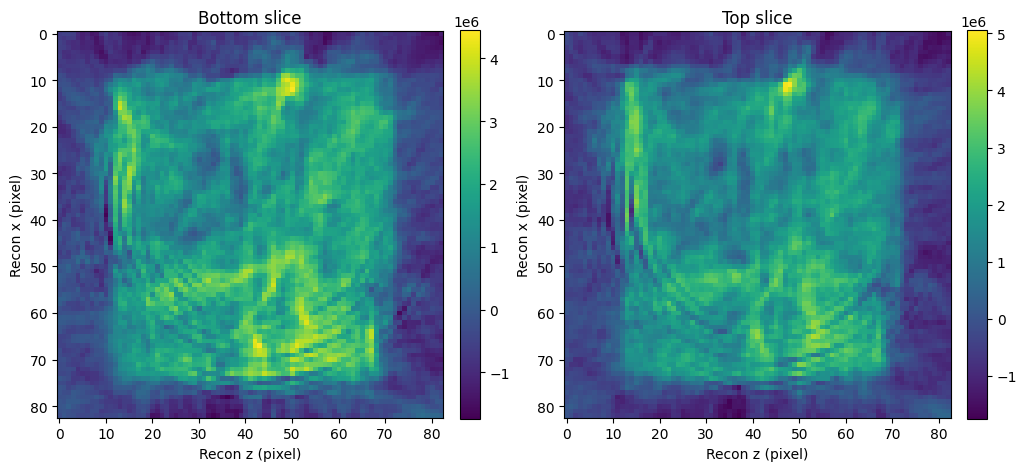

In [8]:
tot_intensity_sino = np.sum(full_sinogramm/curr_array, axis = (3,4))
fbp = FBP(tot_intensity_sino, geometry_3d)
fbp.shape

fig, axs = plt.subplots(1,2, figsize = (12,12))
im1 = axs[0].imshow(fbp[:,:,0])
axs[0].set_xlabel('Recon z (pixel)'); axs[0].set_ylabel('Recon x (pixel)'); axs[0].set_title('Bottom slice')
fig.colorbar(im1,orientation='vertical',fraction=0.046, pad=0.04)

im1 = axs[1].imshow(fbp[:,:,-1])
axs[1].set_xlabel('Recon z (pixel)'); axs[1].set_ylabel('Recon x (pixel)'); axs[1].set_title('Top slice')
fig.colorbar(im1,orientation='vertical',fraction=0.046, pad=0.04)
fig.show()


## Get reconstruction to draw the mask

+ **mask_threshold** : Pick a threshold value to determine what pixels to plot.

In [9]:
mask_threshold = 5e5
sample_mask = fbp > mask_threshold

Use scipy closing and filling binary operations to get a cleam mask onto the sample reconstruction. <br />
The histogram should show 2 bumps (in air *vs* in sample pixels), and the threshold should separates the two.

/tmp/ipykernel_3741834/362916542.py:1: DeprecationWarning: Please import `binary_closing` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_closing, binary_fill_holes
/tmp/ipykernel_3741834/362916542.py:1: DeprecationWarning: Please import `binary_fill_holes` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_closing, binary_fill_holes


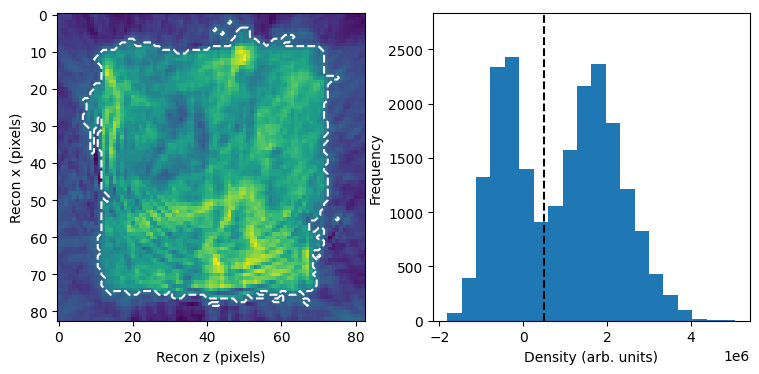

In [10]:
from scipy.ndimage.morphology import binary_closing, binary_fill_holes

for iz in range(sample_mask.shape[2]):
    sample_mask[..., iz] = binary_fill_holes(sample_mask[..., iz])

plt.figure(figsize = (9, 4))

plt.subplot(1,2,1)
plt.imshow(fbp[:,:,0])
plt.contour(sample_mask[:,:,0], levels = [0.5], colors=[(1,1,1)],linestyles='dashed')
plt.xlabel('Recon z (pixels)'); plt.ylabel('Recon x (pixels)');

plt.subplot(1,2,2)
freq = plt.hist(fbp.flatten(), bins = 20)[0]
plt.ylim(0, np.max(freq[5:])*1.2)
plt.plot([mask_threshold]*2, [0, np.max(freq[5:])*1.2], 'k--')
plt.xlabel('Density (arb. units)')
plt.ylabel('Frequency')
plt.show()

Plot the top and bottom slice of the current sample to check the mask

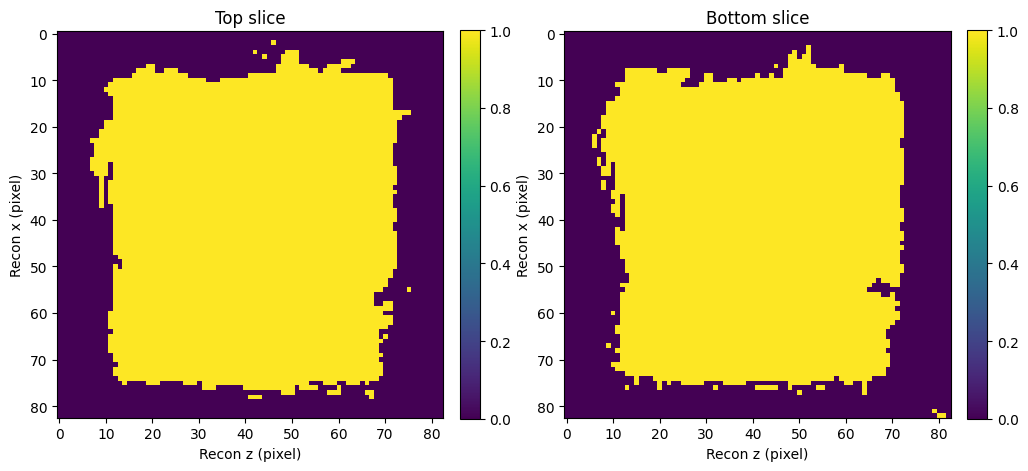

In [11]:
fig, axs = plt.subplots(1,2, figsize = (12,12))

im1 = axs[0].imshow(sample_mask[:,:,0])
axs[0].set_xlabel('Recon z (pixel)')
axs[0].set_ylabel('Recon x (pixel)')
axs[0].set_title('Top slice')
fig.colorbar(im1,orientation='vertical',fraction=0.046, pad=0.04)

im1 = axs[1].imshow(sample_mask[:,:,-1])
axs[1].set_xlabel('Recon z (pixel)')
axs[1].set_ylabel('Recon x (pixel)')
axs[1].set_title('Bottom slice')
fig.colorbar(im1,orientation='vertical',fraction=0.046, pad=0.04)

fig.show()

## Correct for the absorption coefficient

Look this up in a data table. The number should be the absorption coefficient for one reconstructino voxel. <br />
I.e. your stepsize in cm times the usual mu in (1/cm).
+ **absorption_coefficient_pixel_units**: abs_coefficient (in cm-1) * (step size on the experimental device)

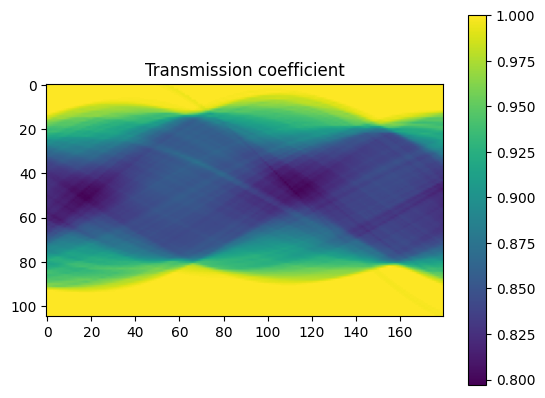

In [12]:
absorption_coefficient_pixel_units = 8.7 * (0.003/10)

projector = Projector(geometry_3d)
projected_thickness = projector.forward(sample_mask[:,:,:, np.newaxis].astype(float))[...,0]
transmission_coefficient = np.exp(-projected_thickness*absorption_coefficient_pixel_units)

fig = plt.figure()
plt.imshow(transmission_coefficient[:, :,0].T)
plt.title('Transmission coefficient')
plt.colorbar()
fig.show()


Save modeled transmission and then normalize out the full sinogram.

In [13]:
np.save('auxillary_files/modeled_transmission.npy', transmission_coefficient[..., np.newaxis, np.newaxis])
data_array = full_sinogramm / curr_array / transmission_coefficient[..., np.newaxis, np.newaxis]


## Estimate scaling factors

Compute q-space direction for each measurement point

In [14]:
coordinates = []
for twotheta in twotheta_list:
    geometry_3d.two_theta = twotheta * np.pi / 180
    coordinates.append(geometry_3d.probed_coordinates.vector[:,:,1,:])
coordinates = np.stack(coordinates, axis = -1)
coordinates = coordinates.transpose((0, 1, 3,2))[:, np.newaxis, np.newaxis, ...]
print(coordinates.shape)

(180, 1, 1, 900, 9, 3)


The plot below shows the pole figure of 2 hkls that should be similar (*i.e.* 110 and 220 or 100 and 200). <br />

/home/esrf/ljegou/.local/lib/python3.11/site-packages/odftt/plot_tools/data_plots.py:17: RuntimeWarning: invalid value encountered in divide
  mean_intensity = sum_int[0] / norm[0]
/home/esrf/ljegou/.local/lib/python3.11/site-packages/odftt/plot_tools/data_plots.py:17: RuntimeWarning: invalid value encountered in divide
  mean_intensity = sum_int[0] / norm[0]


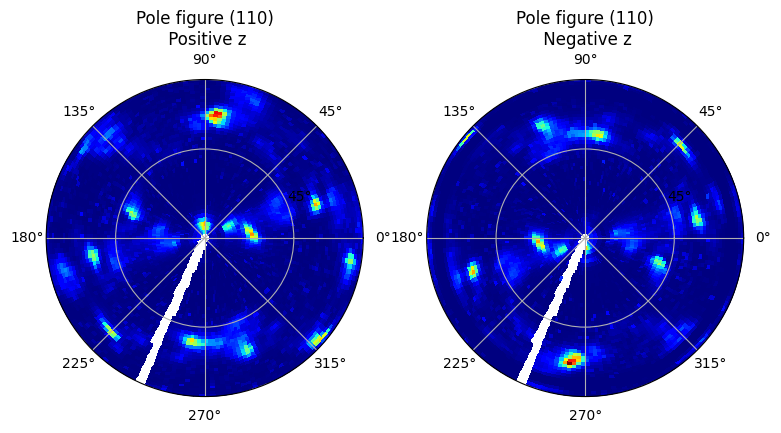

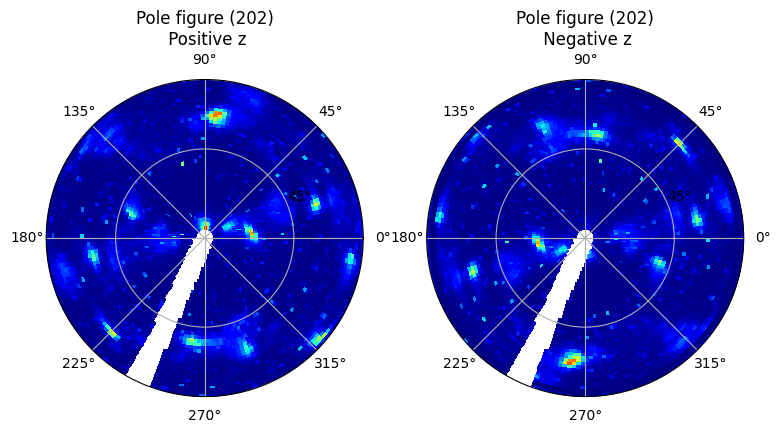

In [15]:
import odftt.plot_tools

# Compute sample-corridnte vector probled for each data point. 
coordinates = []
for twotheta in twotheta_list:
    geometry.two_theta = twotheta * np.pi / 180
    coordinates.append(geometry.probed_coordinates.vector[:,:,1,:])
coordinates = np.stack(coordinates, axis = -1)
coordinates = coordinates.transpose((0,1,3,2))[:,np.newaxis,np.newaxis,:,:,:]

 # Look at the raw data
hkl_index = 0
fig, axs = odftt.plot_tools.plot_experimental_polefigure(np.sum(data_array[...,hkl_index], axis =(1,2)),
                                                         hkl_list[hkl_index], coordinates[...,hkl_index,:],
                                                         resolution_in_degrees=2)

fig.show()

 # Look at the raw data
hkl_index = 3
fig, axs = odftt.plot_tools.plot_experimental_polefigure(np.sum(data_array[...,hkl_index], axis =(1,2)),
                                                         hkl_list[hkl_index], coordinates[...,hkl_index,:],
                                                         resolution_in_degrees=2)

fig.show()

Get the scaling factors associated to each hkls (normalised to 1).

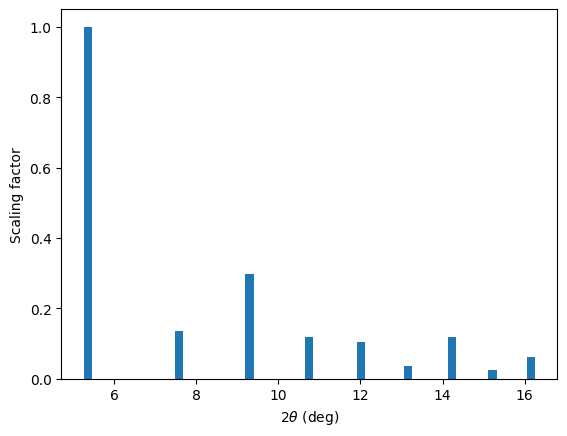

In [16]:
solidangle_factor = np.abs(np.sin(np.deg2rad(azim_angles)))[np.newaxis, np.newaxis, np.newaxis, :, np.newaxis] * np.ones(data_array.shape)
intensity_scaling_factors = np.mean(data_array * solidangle_factor, axis = (0,1,2,3)) / np.mean(solidangle_factor, axis = (0,1,2,3))

# uncomment the next line to get scaling factors normalized to 1
intensity_scaling_factors = intensity_scaling_factors/intensity_scaling_factors[0]

fig = plt.figure()
plt.bar(twotheta_list, intensity_scaling_factors, 0.2)
plt.xlabel(r'$2\theta\text{ (deg)}$')
plt.ylabel('Scaling factor')
fig.show()

Normalize intensity factors out of data, and plot the new sinogram and associated reconstruction.

In [17]:
data_array = data_array / intensity_scaling_factors[np.newaxis, np.newaxis, np.newaxis, np.newaxis, :]

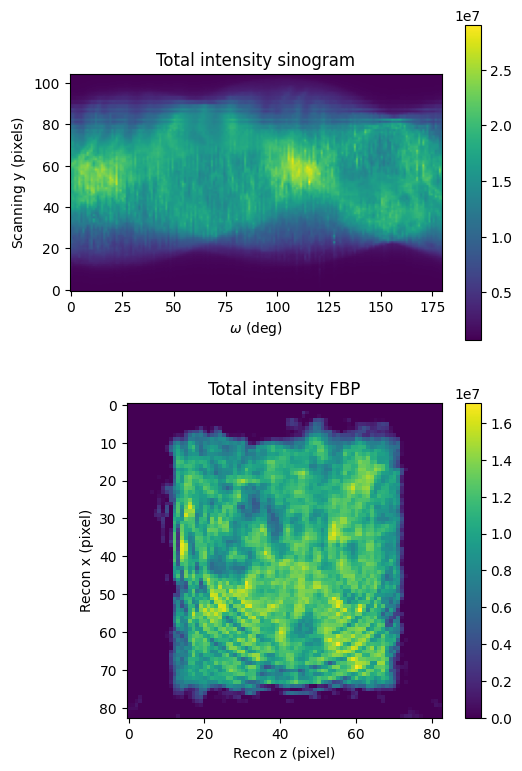

In [18]:
fig = plt.figure(figsize = (6,9))

plt.subplot(2,1,1)

total_intensity_sinogram = np.sum(data_array, axis = (3,4))
extent = (rot_angles[0]-rot_angle_stepsize/2, rot_angles[-1]+rot_angle_stepsize/2, -0.5, data_array.shape[1]-0.5)
plt.imshow(total_intensity_sinogram[:,:, 0].T, extent = extent)
plt.colorbar()
plt.xlabel(r'$\omega\text{ (deg)}$')
plt.ylabel(r'$\text{Scanning y (pixels)}$')
plt.title('Total intensity sinogram')

fbp = FBP(total_intensity_sinogram, geometry_3d)

plt.subplot(2,1,2)
plt.imshow(fbp[:,:,0], vmin = 0)
plt.xlabel('Recon z (pixel)')
plt.ylabel('Recon x (pixel)')
plt.colorbar()
plt.title('Total intensity FBP')
fig.show()

## Save data
and geometry

In [19]:
gap_mask = np.load('auxillary_files/gap_mask.npy')
geometry_2d.write('auxillary_files/2d.mumottgeometry')
geometry_3d.write('auxillary_files/3d.mumottgeometry')

with h5py.File(f'auxillary_files/{sample}_corrected_data.h5', 'w') as file:
    file.create_dataset('rotangle_degrees', data = rot_angles)
    file.create_dataset('aziangle_degrees', data = azim_angles)
    file.create_dataset('data_array', data = data_array)
    file.create_dataset('twotheta_list', data = twotheta_list)
    file.create_dataset('hkl_list', data = hkl_list)
    file.create_dataset('gap_mask', data = gap_mask)
    file.create_dataset('coordinates', data = coordinates)    